<a href="https://colab.research.google.com/github/aichajeral1/aichajeral1/blob/main/GWP_1_MScFE622_Stochastic_Modeling_Group_3588_rev02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MScFE 622 Stochastic Modeling Group Work Project # 1
Authors: Jatin Patni, Olabode Samuel James and Eugene Aicha

Group No:  3588

## Summary -

As needed for pricing of options under various assumptions to achieve near real-market result, this project focused on modeling Stochastic Volatility under Heston(1993) Model and Lewis(2001) pricing approach, Combining Stochastic Volatility with Jump Diffusion under the Bates(1996) under Lewis(2001) and Carr-Madan(1999) pricing approaches.

Euribor 12-month Interest rates was also modeled and calibrated under CIR(1985) to the observed real world interest rate.

Bates(1996) Jump component was accomplished through the adjusted Merton Methods.

Accompanying codes, plots and deductions have been well enumerated in this report.

## Import Libraries

In [ ]:
#Standard Python Library for Tabular data
import pandas as pd
import numpy as np

#library for optimization
from scipy.optimize import brute, fmin
from scipy.optimize import minimize

#library for Lewis 2001 Quadrature - summation of integral
from scipy.integrate import quad


#library for Ploting the Charts
import matplotlib.pyplot as plt

#Access to the Math Library in Python
import math

In [ ]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


### Common Parameters

In [ ]:
#Parameters

S0 = 232.90
num_days_year = 250 # assume trading days in a year
r = 1.5/100 # constant annual risk-free rate of 1.50%

## Options Data


### Importing the Dataset from excel

In [ ]:
data = pd.read_excel("MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx")

In [ ]:
data.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


In [ ]:
# Required for calibration in this format
options_df = data.pivot(index=["Days to maturity", "Strike"], columns="Type", values="Price").reset_index()
options_df.columns = ["Maturity", "Strike", "Call", "Put"]

In [ ]:
# Adding Time-to-Maturity and constant short-rates
for row, option in options_df.iterrows():
    T = option["Maturity"] / num_days_year
    options_df.loc[row, "T"] = T
    options_df.loc[row, "r"] = r  # ECB base rate

In [ ]:
options_data = options_df.copy()

In [ ]:
options_data.head()

,Maturity,Strike,Call,Put,T,r
0,15,227.5,10.52,4.32,0.06,0.015
1,15,230.0,10.05,5.20,0.06,0.015
2,15,232.5,7.75,6.45,0.06,0.015
3,15,235.0,6.01,7.56,0.06,0.015
4,15,237.5,4.75,8.78,0.06,0.015


## Helper Classes and Functions

### Heston Model Calibration

In [ ]:
#Calibration Parameters
i = 0
min_MSE = 500

In [ ]:
#Step 1/2
def H93_calibration_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

#Step 2/2
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []

    #Here we will be calibrating for the Put and Call Prices at thesame time
    for row, option in options_data.iterrows():
        model_call_value = H93_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        #We use Put Call Parity to Obtain the Comparative put value for model evaluation
        model_put_value = calculate_put_price(model_call_value, S0, option["Strike"], option["r"], option["T"])
        se.append((model_call_value - option["Call"]) ** 2)
        se.append((model_put_value - option["Put"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

Step 2 - Modified for Carr Madan

In [ ]:
#Step 1/2
def H93_calibration_carr_madan_full():
    """Calibrates Heston (1993) stochastic volatility model to market quotes."""
    # First run with brute force
    # (scan sensible regions, for faster convergence)
    p0 = brute(
        H93_error_function,
        (
            (2.5, 10.6, 5.0),  # kappa_v
            (0.01, 0.041, 0.01),  # theta_v
            (0.05, 0.251, 0.1),  # sigma_v
            (-0.75, 0.01, 0.25),  # rho
            (0.01, 0.031, 0.01),
        ),  # v0
        finish=None,
    )

    # Second run with local, convex minimization
    # (we dig deeper where promising results)
    opt = fmin(
        H93_error_function, p0, xtol=0.000001, ftol=0.000001, maxiter=750, maxfun=900
    )
    return opt

#Step 2/2
def H93_error_function(p0):
    """Error function for parameter calibration via
    Lewis (2001) Fourier approach for Heston (1993).
    Parameters
    ==========
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial, instantaneous variance
    Returns
    =======
    MSE: float
        mean squared error
    """
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0 = p0
    if kappa_v < 0.0 or theta_v < 0.005 or sigma_v < 0.0 or rho < -1.0 or rho > 1.0:
        return 500.0
    if 2 * kappa_v * theta_v < sigma_v**2:
        return 500.0
    se = []

    #Here we will be calibrating for the Put and Call Prices at thesame time
    for row, option in options_data.iterrows():
        model_call_value = H93_call_FFT( #links to the FFT Approach under Carr-Madan
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
        )
        #We use Put Call Parity to Obtain the Comparative put value for model evaluation
        model_put_value = calculate_put_price(model_call_value, S0, option["Strike"], option["r"], option["T"])
        se.append((model_call_value - option["Call"]) ** 2)
        se.append((model_put_value - option["Put"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

###Bates(1996)

#### Bates Calibrator

Under Lewis 2001

In [ ]:
def B96_calibration_full():
    opt = fmin(
        B96_full_error_function, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

def B96_full_error_function(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_data.iterrows():
        model_call_value = B96_call_value(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        model_put_value = calculate_put_price(model_call_value, S0, option["Strike"], option["r"], option["T"])

        #To allow for calibration for both call and put values at thesame time
        se.append((model_call_value - option["Call"]) ** 2)
        se.append((model_put_value - option["Put"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

Under Carr-Madan

In [ ]:
def B96_calibration_full_carr_madan():
    opt = fmin(
        B96_full_error_function_carr, p0, xtol=0.001, ftol=0.001, maxiter=1250, maxfun=650
    )
    return opt

In [ ]:
i = 0
min_MSE = 5000.0
local_opt = False

def B96_full_error_function_carr(p0):
    global i, min_MSE
    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = p0

    if (
        kappa_v < 0.0
        or theta_v < 0.005
        or sigma_v < 0.0
        or rho < -1.0
        or rho > 1.0
        or v0 < 0.0
        or lamb < 0.0
        or mu < -0.6
        or mu > 0.0
        or delta < 0.0
    ):
        return 5000.0

    if 2 * kappa_v * theta_v < sigma_v**2:
        return 5000.0

    se = []
    for row, option in options_data.iterrows():
        model_call_value = B96_call_FFT(
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        model_put_value = calculate_put_price(model_call_value, S0, option["Strike"], option["r"], option["T"])

        #To allow for calibration for both call and put values at thesame time
        se.append((model_call_value - option["Call"]) ** 2)
        se.append((model_put_value - option["Put"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    return MSE

##### Bates Short Calibrator

In [ ]:
def B96_calibration_short():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_data.iterrows():
        model_call_value = B96_call_value( #Under Lewis 2001
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        model_put_value = calculate_put_price(model_call_value, S0, option["Strike"], option["r"], option["T"])

        #To allow for calibration for both call and put values at thesame time
        se.append((model_call_value - option["Call"]) ** 2)
        se.append((model_put_value - option["Put"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

In [ ]:
#Bates Short Calibrator under Carr_madan_FFT
def B96_calibration_short_carr_madan():
    """
    Calibrates jump component of Bates (1996) model to market prices
    """
    # First, we run with brute force
    # (scan sensible regions)
    opt1 = 0.0
    opt1 = brute(
        B96_error_function,
        (
            (0.0, 0.51, 0.1),  # lambda
            (-0.5, -0.11, 0.1),  # mu
            (0.0, 0.51, 0.25),
        ),  # delta
        finish=None,
    )

    # Second, we run with local, convex minimization
    # (dig deeper where promising)
    opt2 = fmin(
        B96_error_function,
        opt1,
        xtol=0.0000001,
        ftol=0.0000001,
        maxiter=550,
        maxfun=750,
    )
    return opt2

def B96_error_function(p0):
    """
    Error function for Bates (1996) model

    Parameters:
    -------------
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    Returns
    -------------
    MSE: float
        mean squared error
    """

    global i, min_MSE, local_opt, opt1
    lamb, mu, delta = p0
    if lamb < 0.0 or mu < -0.6 or mu > 0.0 or delta < 0.0:
        return 5000.0
    se = []
    for row, option in options_data.iterrows():
        model_call_value = B96_call_FFT( #Under Lewis 2001
            S0,
            option["Strike"],
            option["T"],
            option["r"],
            kappa_v,
            theta_v,
            sigma_v,
            rho,
            v0,
            lamb,
            mu,
            delta,
        )

        model_put_value = calculate_put_price(model_call_value, S0, option["Strike"], option["r"], option["T"])

        #To allow for calibration for both call and put values at thesame time
        se.append((model_call_value - option["Call"]) ** 2)
        se.append((model_put_value - option["Put"]) ** 2)

    MSE = sum(se) / len(se)
    min_MSE = min(min_MSE, MSE)
    if i % 25 == 0:
        print("%4d |" % i, np.array(p0), "| %7.3f | %7.3f" % (MSE, min_MSE))
    i += 1
    if local_opt:
        penalty = np.sqrt(np.sum((p0 - opt1) ** 2)) * 1
        return MSE + penalty
    return MSE

Defining the Bates Characteristic function as

Bates = Heston * adjusted Merton

In [ ]:
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

def M76J_char_func(u, T, lamb, mu, delta):
    """
    Adjusted Characteristic function for Merton '76 model: Only jump component
    """

    omega = -lamb * (np.exp(mu + 0.5 * delta**2) - 1)
    char_func_value = np.exp(
        (1j * u * omega + lamb * (np.exp(1j * u * mu - u**2 * delta**2 * 0.5) - 1))
        * T
    )
    return char_func_value

def B96_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Bates (1996) characteristic function
    """
    H93 = H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0)
    M76J = M76J_char_func(u, T, lamb, mu, delta)
    return H93 * M76J

In [ ]:
def B96_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Valuation of European call option in B96 Model via Lewis (2001)
    Parameters:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    lamb: float
        jump intensity
    mu: float
        expected jump size
    delta: float
        standard deviation of jump
    ==========
    """
    int_value = quad(
        lambda u: B96_int_func(
            u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
        ),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

#### Bates under Lewis(2001) Approach

Specifying the Bates Integral

In [ ]:
def B96_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Lewis (2001) integral value for Bates (1996) characteristic function
    """
    char_func_value = B96_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value

#### Bates under Carr-madan(1999) Approach

In [ ]:
def B96_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta):
    """
    Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            B96_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - B96_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta
            )
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

### Visualizer

Graphical Plot of Heston under Lewis

In [ ]:
# H93_call_FFT(S0, K, r, T, kappa, theta, sigma, rho, v0)

def generate_plot_HESTON_Lewis(options):

    # First, we calculate model prices
    options["Model Call Price"] = 0.0
    options["Model Put Price"] = 0.0

    for row, option in options.iterrows():
        call_price = H93_call_FFT(
            S0, option["Strike"], option["r"], option["T"], kappa_v, theta_v, sigma_v, rho, v0)

        options.loc[row, "Model Call Price"] = call_price
        options.loc[row, "Model Put Price"] = calculate_put_price(call_price, S0, option["Strike"], option["r"], option["T"])

    # Second, we plot
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'lightblue'
    plt.plot(options["Strike"], options["Model Call Price"], label='Model Call Prices')
    plt.plot(options["Strike"], options["Model Put Price"], label='Model Put Prices')
    plt.scatter(options['Strike'], options['Call'], color='red', label='Actual Call Prices')
    plt.scatter(options['Strike'], options['Put'], color='blue', label='Actual Put Prices')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Calibrated Heston Model - Carr-Madan Prices vs. Observed Prices for 15 Day Maturity')
    plt.legend()
    plt.grid(True)
    plt.show()

Graphical Plot for Bates under Carr-Madan

In [ ]:
def generate_plot_bates_carr(options, parameters):

    # First, we calculate model prices
    options["Model Call Price"] = 0.0
    options["Model Put Price"] = 0.0

    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = parameters


    for row, option in options.iterrows():
        call_price = B96_call_FFT(
            S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)

        options.loc[row, "Model Call Price"] = call_price
        options.loc[row, "Model Put Price"] = calculate_put_price(call_price, S0, option["Strike"], option["r"], option["T"])

    # Second, we plot
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'lightblue'
    plt.plot(options["Strike"], options["Model Call Price"], label='Model Call Prices')
    plt.plot(options["Strike"], options["Model Put Price"], label='Model Put Prices')
    plt.scatter(options['Strike'], options['Call'], color='red', label='Actual Call Prices')
    plt.scatter(options['Strike'], options['Put'], color='blue', label='Actual Put Prices')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Calibrated Bates Model Prices vs. Observed Prices for 60 Day Maturity')
    plt.legend()
    plt.grid(True)
    plt.show()

Graphical Plot for Bates under Lewis

In [ ]:
def generate_plot_BATES_Lewis(options, parameters):

    # First, we calculate model prices
    options["Model Call Price"] = 0.0
    options["Model Put Price"] = 0.0

    kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta = parameters


    for row, option in options.iterrows():
        call_price = B96_call_value(
            S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta)

        options.loc[row, "Model Call Price"] = call_price
        options.loc[row, "Model Put Price"] = calculate_put_price(call_price, S0, option["Strike"], option["r"], option["T"])

    # Second, we plot
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'lightblue'
    plt.plot(options["Strike"], options["Model Call Price"], label='Model Call Prices')
    plt.plot(options["Strike"], options["Model Put Price"], label='Model Put Prices')
    plt.scatter(options['Strike'], options['Call'], color='red', label='Actual Call Prices')
    plt.scatter(options['Strike'], options['Put'], color='blue', label='Actual Put Prices')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Calibrated Bates Model Prices vs. Observed Prices for 60 Day Maturity')
    plt.legend()
    plt.grid(True)
    plt.show()

CIR Calibration

In [ ]:
def plot_calibrated_frc(opt):
    """Plots market and calibrated forward rate curves."""
    forward_rates = CIR_forward_rate(opt)
    plt.figure(figsize=(12, 8))
    plt.subplot(211)
    plt.title("CIR model calibration")
    plt.ylabel("Forward rate $f(0,T)$")
    plt.plot(mat_list_n, f, "ro", label="market")
    plt.plot(mat_list_n, forward_rates, "b--", label="model")
    plt.legend(loc=0)
    plt.axis(
        [min(mat_list_n) - 0.05, max(mat_list_n) + 0.05, min(f) - 0.005, max(f) * 1.1]
    )
    plt.subplot(212)
    wi = 0.02
    plt.bar(mat_list_n - wi / 2, forward_rates - f, width=wi)
    plt.xlabel("Time horizon")
    plt.ylabel("Difference")
    plt.axis(
        [
            min(mat_list_n) - 0.05,
            max(mat_list_n) + 0.05,
            min(forward_rates - f) * 1.1,
            max(forward_rates - f) * 1.1,
        ]
    )
    plt.tight_layout()

def CIR_forward_rate(alpha):
    """
    Forward rates in CIR (1985) model
    The set of parameters is called alpha and include Kappa_r, Theta_r and Sigma_r
    """

    kappa_r, theta_r, sigma_r = alpha

    t = mat_list_n
    g = np.sqrt(kappa_r**2 + 2 * sigma_r**2)

    s1 = (kappa_r * theta_r * (np.exp(g * t) - 1)) / (
        2 * g + (kappa_r + g) * (np.exp(g * t) - 1)
    )

    s2 = r0 * (
        (4 * g**2 * np.exp(g * t)) / (2 * g + (kappa_r + g) * (np.exp(g * t)) ** 2)
    )

    return s1 + s2

###Lewis (2001) - Fourier pricing method

In [ ]:
#Step 1/3
def H93_call_value(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)

    Parameter definition:
    ==========
    S0: float
        initial stock/index level
    K: float
        strike price
    T: float
        time-to-maturity (for t=0)
    r: float
        constant risk-free short rate
    kappa_v: float
        mean-reversion factor
    theta_v: float
        long-run mean of variance
    sigma_v: float
        volatility of variance
    rho: float
        correlation between variance and stock/index level
    v0: float
        initial level of variance
    Returns
    =======
    call_value: float
        present value of European call option
    """
    int_value = quad(
        lambda u: H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0),
        0,
        np.inf,
        limit=250,
    )[0]
    call_value = max(0, S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * int_value)
    return call_value

#Step 2/3
def H93_int_func(u, S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Fourier-based approach for Lewis (2001): Integration function.
    """
    char_func_value = H93_char_func(
        u - 1j * 0.5, T, r, kappa_v, theta_v, sigma_v, rho, v0
    )
    int_func_value = (
        1 / (u**2 + 0.25) * (np.exp(1j * u * np.log(S0 / K)) * char_func_value).real
    )
    return int_func_value


#Step3/3
def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value



### Carr-Madan(1999) - FFT Approach

In [ ]:
#Modelling just Stochastic Volatility with no Jump
#Step 1/1 - Under Carr Madan
def H93_call_FFT(S0, K, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """
    Modified from the Call option price in Bates (1996) under FFT
    """

    k = np.log(K / S0)
    g = 1  # Factor to increase accuracy
    N = g * 4096
    eps = (g * 150) ** -1
    eta = 2 * np.pi / (N * eps)
    b = 0.5 * N * eps - k
    u = np.arange(1, N + 1, 1)
    vo = eta * (u - 1)

    # Modifications to ensure integrability
    if S0 >= 0.95 * K:  # ITM Case
        alpha = 1.5
        v = vo - (alpha + 1) * 1j
        modcharFunc = np.exp(-r * T) * (
            H93_char_func(v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / (alpha**2 + alpha - vo**2 + 1j * (2 * alpha + 1) * vo)
        )

    else:
        alpha = 1.1
        v = (vo - 1j * alpha) - 1j
        modcharFunc1 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo - 1j * alpha))
            - np.exp(r * T) / (1j * (vo - 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo - 1j * alpha) ** 2 - 1j * (vo - 1j * alpha))
        )

        v = (vo + 1j * alpha) - 1j

        modcharFunc2 = np.exp(-r * T) * (
            1 / (1 + 1j * (vo + 1j * alpha))
            - np.exp(r * T) / (1j * (vo + 1j * alpha))
            - H93_char_func(
                v, T, r, kappa_v, theta_v, sigma_v, rho, v0)
            / ((vo + 1j * alpha) ** 2 - 1j * (vo + 1j * alpha))
        )

    # Numerical FFT Routine
    delt = np.zeros(N)
    delt[0] = 1
    j = np.arange(1, N + 1, 1)
    SimpsonW = (3 + (-1) ** j - delt) / 3
    if S0 >= 0.95 * K:
        FFTFunc = np.exp(1j * b * vo) * modcharFunc * eta * SimpsonW
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = np.exp(-alpha * k) / np.pi * payoff
    else:
        FFTFunc = (
            np.exp(1j * b * vo) * (modcharFunc1 - modcharFunc2) * 0.5 * eta * SimpsonW
        )
        payoff = (np.fft.fft(FFTFunc)).real
        CallValueM = payoff / (np.sinh(alpha * k) * np.pi)

    pos = int((k + b) / eps)
    CallValue = CallValueM[pos] * S0

    return CallValue

def H93_char_func(u, T, r, kappa_v, theta_v, sigma_v, rho, v0):
    """Valuation of European call option in H93 model via Lewis (2001)
    Fourier-based approach: characteristic function.
    Parameter definitions see function BCC_call_value."""
    c1 = kappa_v * theta_v
    c2 = -np.sqrt(
        (rho * sigma_v * u * 1j - kappa_v) ** 2 - sigma_v**2 * (-u * 1j - u**2)
    )
    c3 = (kappa_v - rho * sigma_v * u * 1j + c2) / (
        kappa_v - rho * sigma_v * u * 1j - c2
    )
    H1 = r * u * 1j * T + (c1 / sigma_v**2) * (
        (kappa_v - rho * sigma_v * u * 1j + c2) * T
        - 2 * np.log((1 - c3 * np.exp(c2 * T)) / (1 - c3))
    )
    H2 = (
        (kappa_v - rho * sigma_v * u * 1j + c2)
        / sigma_v**2
        * ((1 - np.exp(c2 * T)) / (1 - c3 * np.exp(c2 * T)))
    )
    char_func_value = np.exp(H1 + H2 * v0)
    return char_func_value

### CIR Calibration

In [ ]:
def CIR_calibration():
    opt = fmin(
        CIR_error_function,
        [1.0, 0.02, 0.1],
        xtol=0.00001,
        ftol=0.00001,
        maxiter=300,
        maxfun=500,
    )

    return opt

def CIR_error_function(alpha):
    """
    Error function to calibrate CIR (1985) model
    """

    kappa_r, theta_r, sigma_r = alpha

    # Few remarks to avoid problems for certain values of parameters:
    if 2 * kappa_r * theta_r < sigma_r**2:
        return 100
    if kappa_r < 0 or theta_r < 0 or sigma_r < 0.001:
        return 100

    forward_rates = CIR_forward_rate(alpha)
    MSE = np.sum((f - forward_rates) ** 2) / len(f)

    return MSE

### Put-Call Parity
- For obtaining the put price from the call price

In [ ]:
def calculate_put_price(call_price, S, K, r, T):
    """Calculate the price of a put option using put-call parity."""
    put_price = call_price - S + K * np.exp(-r * T)
    return put_price

### Option Pricer - Vanilla - American, European and Asian
- This Class is just for purpose of testing and comparing model results

In [ ]:
from scipy.stats import norm

class OptionPricer:
    def __init__(self, S, K, r, sigma, T):
        self.S = S  # Current stock price
        self.K = K  # Strike price
        self.r = r  # Risk-free interest rate
        self.sigma = sigma  # Volatility of the underlying asset
        self.T = T  # Time to maturity (in years)

    def european_option(self, option_type):
        d1 = (np.log(self.S / self.K) + (self.r + 0.5 * self.sigma**2) * self.T) / (self.sigma * np.sqrt(self.T))
        d2 = d1 - self.sigma * np.sqrt(self.T)

        if option_type == 'call':
            price = self.S * norm.cdf(d1) - self.K * np.exp(-self.r * self.T) * norm.cdf(d2)
        elif option_type == 'put':
            price = self.K * np.exp(-self.r * self.T) * norm.cdf(-d2) - self.S * norm.cdf(-d1)
        else:
            raise ValueError("Invalid option type. Choose 'call' or 'put'.")

        return price

    def asian_option(self, option_type, num_simulations):
        np.random.seed(0)  # Set random seed for reproducibility

        S_paths = np.zeros((num_simulations, self.T+1))
        S_paths[:, 0] = self.S

        for t in range(1, self.T+1):
            z = np.random.standard_normal(num_simulations)
            S_paths[:, t] = S_paths[:, t-1] * np.exp((self.r - 0.5 * self.sigma**2) + self.sigma * np.sqrt(1/self.T) * z)

        avg_price = np.mean(S_paths[:, 1:], axis=1)

        if option_type == 'call':
            payoff = np.maximum(avg_price - self.K, 0)
        elif option_type == 'put':
            payoff = np.maximum(self.K - avg_price, 0)
        else:
            raise ValueError("Invalid option type. Choose 'call' or 'put'.")

        price = np.exp(-self.r * self.T) * np.mean(payoff)

        return price

    def american_option(self, option_type, num_steps):
        dt = self.T / num_steps
        discount_factor = np.exp(-self.r * dt)

        # Initialize arrays for stock prices and option values
        S_paths = np.zeros((num_steps+1,))
        V = np.zeros((num_steps+1,))

        # Set initial values
        S_paths[0] = self.S

        for i in range(1, num_steps+1):
            z = np.random.standard_normal()
            S_paths[i] = S_paths[i-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * z)

        if option_type == 'call':
            V[-1] = np.maximum(S_paths[-1] - self.K, 0)
        elif option_type == 'put':
            V[-1] = np.maximum(self.K - S_paths[-1], 0)
        else:
            raise ValueError("Invalid option type. Choose 'call' or 'put'.")

        for j in range(num_steps-1, -1, -1):
            z = np.random.standard_normal()
            S_t = S_paths[j]
            intrinsic_value = np.maximum(S_t - self.K, 0) if option_type == 'call' else np.maximum(self.K - S_t, 0)
            continuation_value = discount_factor * ((1 / num_simulations) * np.sum(V[j+1]) if j != num_steps-1 else np.sum(V[j+1]))
            V[j] = np.maximum(intrinsic_value, continuation_value)

        price = V[0] * np.exp(-self.r * self.T)

        return price


In [ ]:
# Example usage
S = 100  # Current stock price
K = 200  # Strike price
r = 0.05  # Risk-free interest rate
sigma = 0.2  # Volatility of the underlying asset
T = 1  # Time to maturity (in years)
num_simulations = 10000  # Number of simulations for Asian option
num_steps = 100  # Number of steps for American option

option_pricer = OptionPricer(S, K, r, sigma, T)
european_call_price = option_pricer.european_option('call')
european_put_price = option_pricer.european_option('put')
asian_call_price = option_pricer.asian_option('call', num_simulations)
asian_put_price = option_pricer.asian_option('put', num_simulations)
american_call_price = option_pricer.american_option('call', num_steps)
american_put_price = option_pricer.american_option('put', num_steps)

print("European Call Price:", round(european_call_price,5))
print("European Put Price:", round(european_put_price,5))
print("Asian Call Price:", round(asian_call_price,5))
print("Asian Put Price:", round(asian_put_price,5))
print("American Call Price:", round(american_call_price,5))
print("American Put Price:", round(american_put_price,5))

European Call Price: 0.0048
European Put Price: 90.25068
Asian Call Price: 0.00237
Asian Put Price: 90.66232
American Call Price: 0.0
American Put Price: 95.12294


#### Pricing Asian Option Under Monte Carlo

In [ ]:
import numpy as np
from scipy.special import erf


class AsianOptionMC_MC(object):
    """ Class for Asian options pricing using control variate and monte carlo simulations
    S0 : float : initial stock/index level
    strike : float : strike price
    T : float : time to maturity (in year fractions)
    M : int : grid or granularity for time (in number of total points)
    r : float : constant risk-free short rate
    div :    float : dividend yield
    sigma :  float : volatility factor in diffusion term

    Unitest (doctest):
    >>> myAsianCall = AsianOptionMC_MC('call', 4., 4., 1., 100., .03, 0, .25, 10000)
    >>> myAsianCall.value
    (0.26141622329842962, 0.25359138249114327, 0.26924106410571597)
    >>> myAsianCall.value_with_control_variate
    (0.25813771282805958, 0.25771678775128265, 0.25855863790483652)

    """

    def __init__(self, option_type, S0, strike, T, M, r, div, sigma, simulations):
        try:
            self.option_type = option_type
            assert isinstance(option_type, str)
            self.S0 = float(S0)
            self.strike = float(strike)
            self.T = float(T)
            self.M = int(M)
            self.r = float(r)
            self.div = float(div)
            self.sigma = float(sigma)
            self.simulations = int(simulations)
        except ValueError:
            print('Error passing Options parameters')

        if option_type != 'call' and option_type != 'put':
            raise ValueError("Error: option type not valid. Enter 'call' or 'put'")
        if S0 < 0 or strike < 0 or T <= 0 or r < 0 or div < 0 or sigma < 0:
            raise ValueError('Error: Negative inputs not allowed')

        self.time_unit = self.T / float(self.M)
        self.discount = np.exp(- self.r * self.T)

    @property
    def GeometricAsianOption(self):
        sigsqT = ((self.sigma ** 2 * self.T * (self.M + 1) * (2 * self.M + 1))
                  / (6 * self.M * self.M))
        muT = (0.5 * sigsqT + (self.r - 0.5 * self.sigma ** 2)
               * self.T * (self.M + 1) / (2 * self.M))
        d1 = ((np.log(self.S0 / self.strike) + (muT + 0.5 * sigsqT))
              / np.sqrt(sigsqT))
        d2 = d1 - np.sqrt(sigsqT)
        N1 = 0.5 * (1 + erf(d1 / np.sqrt(2)))
        N2 = 0.5 * (1 + erf(d2 / np.sqrt(2)))
        geometric_value = self.discount * (self.S0 * np.exp(muT) * N1 - self.strike * N2)
        return geometric_value

    @property
    def price_path(self, seed = 100):
        np.random.seed(seed)
        price_path = (self.S0 *
                      np.cumprod (np.exp ((self.r - 0.5 * self.sigma ** 2) * self.time_unit +
                                    self.sigma * np.sqrt(self.time_unit)
                                          * np.random.randn(self.simulations, self.M)), 1))
        return price_path

    @property
    def MCPayoff(self):
        if self.option_type == 'call':
            MCpayoff = self.discount \
                              * np.maximum(np.mean(self.price_path,1)-self.strike, 0)
        else:
            MCpayoff = self.discount \
                              * np.maximum(self.strike - np.mean(self.price_path,1), 0)
        return MCpayoff

    @property
    def value(self):
        MCvalue = np.mean(self.MCPayoff)
        MCValue_std = np.std(self.MCPayoff)
        upper_bound = MCvalue + 1.96 * MCValue_std/np.sqrt(self.simulations)
        lower_bound = MCvalue - 1.96 * MCValue_std/np.sqrt(self.simulations)
        return [MCvalue, lower_bound, upper_bound]

    @property
    def value_with_control_variate(self):

        geometric_average = np.exp( (1/float(self.M)) * np.sum(np.log(self.price_path), 1) )
        if self.option_type == 'call':
            MCpayoff_geometric = self.discount * np.maximum(geometric_average - self.strike, 0)
        else:
            MCpayoff_geometric = self.discount * np.maximum(self.strike - geometric_average, 0)
        value_with_CV = self.MCPayoff + self.GeometricAsianOption - MCpayoff_geometric
        value_with_control_variate = np.mean(value_with_CV , 0)
        value_with_control_variate_std = np.std(value_with_CV, 0)
        upper_bound_CV = value_with_control_variate + 1.96 * value_with_control_variate_std/np.sqrt(self.simulations)
        lower_bound_CV = value_with_control_variate - 1.96 * value_with_control_variate_std/np.sqrt(self.simulations)
        return value_with_control_variate, lower_bound_CV, upper_bound_CV

#### Pricing Asian Option Under Heston

In [ ]:
#This is to generate the price for an Asian Call Option under Heston Assumptions
#Step 1/2 - Monte-Carlo Simulation
def heston_model_asian_call_simulation(S0, T, r, kappa, theta, sigma, rho, v0, num_paths, num_steps):
    dt = T / num_steps
    sqrt_dt = np.sqrt(dt)

    # Initialize arrays to store the simulated stock prices and volatilities
    S = np.zeros((num_paths, num_steps + 1))
    v = np.zeros((num_paths, num_steps + 1))

    # Set initial values
    S[:, 0] = S0
    v[:, 0] = v0

    # Perform Monte Carlo simulation
    for i in range(num_steps):
        z1 = np.random.normal(size=num_paths)
        z2 = rho * z1 + np.sqrt(1 - rho**2) * np.random.normal(size=num_paths)

        # Update stock price and volatility using the Heston model equations
        S[:, i + 1] = S[:, i] * np.exp((r - 0.5 * v[:, i]) * dt + np.sqrt(v[:, i]) * np.sqrt(dt) * z1)
        v[:, i + 1] = np.maximum(0, v[:, i] + kappa * (theta - v[:, i]) * dt + sigma * np.sqrt(v[:, i]) * np.sqrt(dt) * z2)

    # Calculate the average of the stock prices along each path
    average_S = np.mean(S, axis=1)

    return average_S

#Step 2/2 - Payoff deduction and return value
def asian_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0, num_paths, num_steps):
    average_S = heston_model_asian_call_simulation(S0, T, r, kappa, theta, sigma, rho, v0, num_paths, num_steps)

    # Calculate the Asian option payoff
    asian_payoff = np.maximum(0, average_S - K)

    # Discount the payoff to present value
    discount_factor = np.exp(-r * T)
    asian_option_price = np.mean(asian_payoff) * discount_factor

    return asian_option_price


#### Pricing Asian Option Under Bates

In [ ]:
# Define the Bates (Heston model with jumps) pricing formula for Asian Put options
def bates_asian_option_put_price(params, moneyness):
    kappa, theta, sigma, rho, v0, lam, delta, gamma = params

    # Simulate the stock price paths using the Bates model
    dt = T / 100
    sqrt_dt = np.sqrt(dt)

    s_paths = np.zeros((num_simulations, 101))
    v_paths = np.zeros((num_simulations, 101))
    s_paths[:, 0] = S0
    v_paths[:, 0] = v0

    for i in range(1, 101):
        zv = rho * np.random.normal(size=(num_simulations,))
        zv_j = np.random.normal(size=(num_simulations,))

        v_paths[:, i] = v_paths[:, i - 1] + kappa * (theta - v_paths[:, i - 1]) * dt \
                         + sigma * np.sqrt(v_paths[:, i - 1]) * sqrt_dt * zv \
                         + gamma * np.sqrt(v_paths[:, i - 1]) * sqrt_dt * zv_j

        s_paths[:, i] = s_paths[:, i - 1] * np.exp((r - lam * delta - 0.5 * v_paths[:, i - 1]) * dt \
                                                  + np.sqrt(v_paths[:, i - 1]) * np.sqrt(dt) * np.random.normal(size=(num_simulations,)) \
                                                  + delta * np.sqrt(v_paths[:, i - 1]) * np.sqrt(dt) * np.random.normal(size=(num_simulations,)))

    # Compute the average stock price at each time step
    avg_s_paths = np.mean(s_paths, axis=1)

    # Compute the discounted payoff for Asian Put options
    strike = moneyness * S0
    payoff = np.maximum(strike - avg_s_paths, 0)
    discounted_payoff = np.exp(-r * T) * payoff

    # Compute the Asian Put option price using Monte Carlo simulation
    asian_put_price = np.mean(discounted_payoff)

    return asian_put_price

## Step 1 -



### a. Calibration of Heston model (without jumps) under Lewis(2001) for Call and Put options.

The objective of model calibration is to adjust the parameters of an option pricing model to fit observed market prices, in using the Heston model(without jump) we are attempting to derive the best parameters with the best match to the prices of Call and Put options traded in the market, with emphasis on modeling effectively the Stochastic volatility component.

Steven Heston created the Heston model in 1993 herein referred as Heston(1993) Model, and it is a stochastic volatility model that is commonly used in option pricing. It posits that the underlying asset's volatility follows a stochastic process and incorporates the idea of mean reversion. The model contains various parameters that must be calibrated in order to appropriately reflect market conditions.

We are able to price options using this model, as long as we have the Characteristic function which is the nearest summarization to achieve a closed-form solution, given by:

$$
\
\begin{equation*}
  \varphi^{H} (u, T) = e^{H_1(u, T)+H_2(u,T)\nu_0}
\end{equation*}
$$
\
where

$$
\
\begin{equation*}
  H_1 (u, T) \equiv r_0 uiT + \frac{c_1}{\sigma_\nu^2}\Biggl\{ (\kappa_\nu - \rho \sigma_\nu ui+c_2) T - 2 log \left[ \frac{1-c_3e^{c_2T}}{1-c_3} \right] \Biggl\}
\end{equation*}
$$
$$
\
\begin{equation*}
  H_2 (u, T) \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\sigma_\nu^2} \left[ \frac{1-e^{c_2T}}{1-c_3e^{c_2T}} \right]
\end{equation*}
$$
$$
\
\begin{equation*}
  c_1 \equiv \kappa_\nu \theta_\nu
\end{equation*}
$$
$$
\
\begin{equation*}
  c_2 \equiv - \sqrt{(\rho \sigma_\nu ui - \kappa_\nu)^2 - \sigma_\nu^2(-ui-u^2) }
\end{equation*}
$$
$$
\
\begin{equation*}
  c_3 \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\kappa_\nu - \rho \sigma_\nu ui - c_2}
\end{equation*}
$$

\

Herein:

    S0:
        initial stock/index level
    K:
        strike price
    T:
        time-to-maturity (for t=0)
    r:
        constant risk-free short rate
    kappa_v:
        mean-reversion factor
    theta_v:
        long-run mean of variance
    sigma_v:
        volatility of variance
    rho:
        correlation between variance and stock/index level
    v0:
        initial level of variance



We also need to get a value for the integral in Lewis (2001):

$$
\
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$

Where all parameters - same as previously

In order to calibrate, the following broad procedures are commonly used to calibrate the Heston model using the Lewis (2001) approach:

1. Data Preparation

2. Selection of Calibration Objective and Method - in this case, we can use Mean Square Error. This guides the minimization/optimization process

3. Parameter initialization

4. Optimization process to reduce the gap between observed values and actual values - It optimizes model parameters in order to minimize the error function in relation to market data.

5. Iterate until the best sets of parameters is achieved which fits the market data as accurately as possible.

We will follow the follow functions call Map to achieve the Heston Model Calibration herein, all the stated functions are in the Helper Classes and Function Sub-Section -

Heston Model under Lewis -->  Call/Put Options --> H93_Calibration_full
 ---> H93_error_function ---> Based on Put/Call(Put_Call_Parity function intermediates here) ---> H93_Call_Value ---> H93_int_function(Lewis 2001 introduction for the integral function) --> H93_char_func

Using Lewis 2001 approach Under Heston(1993) to calibrate the model with regular MSE error function.

$S_0 = \$232.9 $

#### Data Preparation for Model Calibration

In [ ]:
#Allowing for short maturity
maturity = 15 #short maturity for her derivative(around 15 days)

options_data = options_df[options_df['Maturity'] == maturity]
options_df.shape, options_data.shape

((15, 6), (5, 6))

In [ ]:
options_data.head(10) #Displaying the data set meeting the stipulated conditions

,Maturity,Strike,Call,Put,T,r
0,15,227.5,10.52,4.32,0.06,0.015
1,15,230.0,10.05,5.20,0.06,0.015
2,15,232.5,7.75,6.45,0.06,0.015
3,15,235.0,6.01,7.56,0.06,0.015
4,15,237.5,4.75,8.78,0.06,0.015


#### Model Calibration and Obtaining Parameters

In [ ]:
params = H93_calibration_full()

   0 | [ 2.5   0.01  0.05 -0.75  0.01] |  20.086 |  20.086
  25 | [ 2.5   0.02  0.05 -0.75  0.02] |  13.406 |   9.546
  50 | [ 2.5   0.02  0.25 -0.75  0.03] |   9.308 |   9.277
  75 | [ 2.5   0.03  0.15 -0.5   0.01] |  18.948 |   9.015
 100 | [ 2.5   0.04  0.05 -0.5   0.02] |  12.679 |   8.761
 125 | [ 2.5   0.04  0.25 -0.5   0.03] |   8.810 |   8.759
 150 | [ 7.5   0.01  0.15 -0.25  0.01] |  20.129 |   8.759
 175 | [ 7.5   0.02  0.05 -0.25  0.02] |  13.421 |   8.759
 200 | [ 7.5   0.02  0.25 -0.25  0.03] |   9.815 |   8.759
 225 | [7.5  0.03 0.15 0.   0.01] |  17.160 |   8.759
 250 | [7.5  0.04 0.05 0.   0.02] |  11.515 |   8.336
 275 | [7.5  0.04 0.25 0.   0.03] |   8.413 |   8.332
 300 | [ 7.10037179  0.05742843  0.11352214 -0.46596154  0.04611934] |   4.121 |   4.121
 325 | [4.9974734  0.12010183 0.03182302 0.72664073 0.09991528] |   0.429 |   0.348
 350 | [5.26301157 0.10921079 0.03854832 0.50754679 0.09195685] |   0.348 |   0.348
 375 | [5.44795767 0.11591707 0.01350021 0.5096079

In [ ]:
kappa_v = params[0]
theta_v = params[1]
sigma_v = params[2]
rho = params[3]
v0 = params[4]

#Outputing the parameters from the previous calibration process
print("Heston(1993) Model Parameters under Lewis 2001")
print("--------------------")
print("mean-reversion factor \u03BA\u1D65 = {}".format(kappa_v))
print("long-run mean of variance \u03B8\u1D65 = {}".format(theta_v))
print("volatility of variance \u03C3\u1D65 = {}".format(sigma_v))
print("correlation between variance and stock/index level \u03C1  = {}".format(rho))
print("initial, instantaneous variance \u03C5\u1D65 = {}".format(v0))
print("--------------------")


Heston(1993) Model Parameters under Lewis 2001
--------------------
mean-reversion factor κᵥ = 5.535576092437131
long-run mean of variance θᵥ = 0.11977135992073158
volatility of variance σᵥ = 2.757603326262676e-06
correlation between variance and stock/index level ρ  = 0.515627205882661
initial, instantaneous variance υᵥ = 0.09023386045689327
--------------------


#### Calibration Process Overview:


We have market data available for vanilla options and used it to calibrate the heston model parameters:
$\kappa_\nu$ , $\theta_\nu$ , $\sigma_\nu$, $\rho$ and $\nu_0$

We found two set of parameters calibrated on:
1.   Call options with maturity of 15 days (this maturity selection is based on investors interest).
2.   Put options with maturity of 15 days (this maturity selection is based on investors interest).

The following functions, and based on the notes from WQU(2023) were used to perform the calibration:
1.   Functions related to Pricing of Call/Put options:
  * H93_char_func (Characteristic function of Heston)
  * H93_int_func (Calculate integral values)
  * H93_call_value (Calculate Call option price)
  * Put_value (Calculated Put option price using put call parity)
2.   Functions related to Calibration:
  * H93_error_function (This is based on mean squared error which we are trying to minimize)
  * H93_calibration_full (Optimize the parameters using a combination of brute force search and fmin functions from scipy.optimize module)

Calibration plots show reasonable fit for both call and put options

#### Visualising Model Fit

In [ ]:
def generate_plot(options):

    # First, we calculate model prices
    options["Model Call Price"] = 0.0
    options["Model Put Price"] = 0.0

    for row, option in options.iterrows():
        call_price = H93_call_value(
            S0, option["Strike"], option["T"], option["r"], kappa_v, theta_v, sigma_v, rho, v0)

        options.loc[row, "Model Call Price"] = call_price
        options.loc[row, "Model Put Price"] = calculate_put_price(call_price, S0, option["Strike"], option["r"], option["T"])

    # Second, we plot
    plt.figure(figsize=(10, 6))
    plt.rcParams['axes.facecolor'] = 'lightblue'
    plt.plot(options["Strike"], options["Model Call Price"], label='Model Call Prices')
    plt.plot(options["Strike"], options["Model Put Price"], label='Model Put Prices')
    plt.scatter(options['Strike'], options['Call'], color='red', label='Actual Call Prices')
    plt.scatter(options['Strike'], options['Put'], color='blue', label='Actual Put Prices')
    plt.xlabel('Strike Price')
    plt.ylabel('Option Price')
    plt.title('Calibrated Heston Model Prices vs. Observed Prices for 15 Day Maturity')
    plt.legend()
    plt.grid(True)
    plt.show()

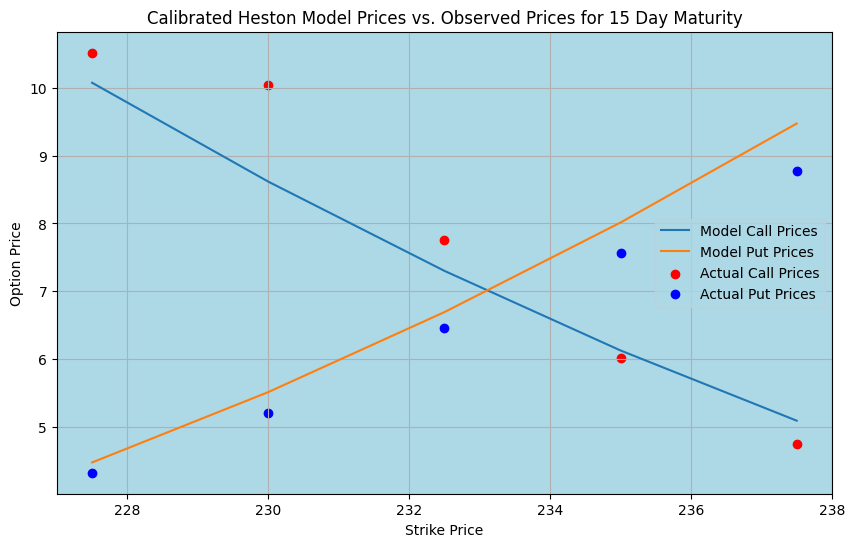

In [ ]:
options_viz = options_data.copy()
generate_plot(options_viz)

###b. Heston Model Calibration under Carr-Madan(1999)

Carr-Madan(1999) is a Fast Fourier Transform algorithm which is an alternative to Lewis (2001). Essentially, we can apply FFT to the integral in the call option price derived by Carr and Madan (1999), represented below:
$$
\
\begin{equation*}
    C_0 = \frac{e^{-\alpha \kappa}}{\pi} \int_{0}^{\infty} e^{-i\nu \kappa} \frac{e^{-rT} \varphi^{H93} (\nu - (\alpha + 1)i, T)}{\alpha^2 + \alpha - \nu^2 + i(2\alpha + 1)\nu} d\nu
\end{equation*}
$$



Where:  all parameters maintain notations as stated previously

#### Data Preparation for Model Calibration

In [ ]:
options_data.head(10) #Displaying the data set meeting the stipulated conditions

,Maturity,Strike,Call,Put,T,r
0,15,227.5,10.52,4.32,0.06,0.015
1,15,230.0,10.05,5.20,0.06,0.015
2,15,232.5,7.75,6.45,0.06,0.015
3,15,235.0,6.01,7.56,0.06,0.015
4,15,237.5,4.75,8.78,0.06,0.015


#### Model Calibration and Obtaining Parameter

Parameters will be

In [ ]:
# Optimization to the given dataset for the  calibration of the Heston model
calibrated_params = H93_calibration_carr_madan_full()

 925 | [2.5  0.01 0.15 0.   0.03] |   9.597 |   0.345
 950 | [ 2.5   0.02  0.25 -0.75  0.01] |  19.586 |   0.345
 975 | [ 2.5   0.03  0.15 -0.75  0.02] |  13.034 |   0.345
1000 | [ 2.5   0.04  0.05 -0.75  0.03] |   8.761 |   0.345
1025 | [ 2.5   0.04  0.25 -0.5   0.01] |  18.465 |   0.345
1050 | [ 7.5   0.01  0.15 -0.5   0.02] |  14.496 |   0.345
1075 | [ 7.5   0.02  0.05 -0.5   0.03] |   9.755 |   0.345
1100 | [ 7.5   0.02  0.25 -0.25  0.01] |  18.618 |   0.345
1125 | [ 7.5   0.03  0.15 -0.25  0.02] |  12.445 |   0.345
1150 | [ 7.5   0.04  0.05 -0.25  0.03] |   8.345 |   0.345
1175 | [7.5  0.04 0.25 0.   0.01] |  15.925 |   0.345
1200 | [ 7.60049628  0.05227639  0.12944609 -0.46553762  0.04475452] |   4.519 |   0.345
1225 | [4.98724122 0.11167779 0.03577665 0.54074403 0.09441751] |   0.353 |   0.345
1250 | [5.23466058 0.11086399 0.03517655 0.52485415 0.09258555] |   0.348 |   0.345
1275 | [5.40271287 0.11499776 0.01702972 0.50740152 0.09088632] |   0.346 |   0.345
1300 | [5.47832513e+

In [ ]:
# Print the calibrated Heston model parameters
kappa_v, theta_v, sigma_v, rho, v0 = calibrated_params

#Outputing the parameters from the previous calibration process
print("Heston(1993) Model Parameters under Carr Madan 1999")
print("--------------------")
print("mean-reversion factor \u03BA\u1D65 = {}".format(kappa_v))
print("long-run mean of variance \u03B8\u1D65 = {}".format(theta_v))
print("volatility of variance \u03C3\u1D65 = {}".format(sigma_v))
print("correlation between variance and stock/index level \u03C1  = {}".format(rho))
print("initial, instantaneous variance \u03C5\u1D65 = {}".format(v0))
print("--------------------")

Heston(1993) Model Parameters under Carr Madan 1999
--------------------
mean-reversion factor κᵥ = 5.535576092437131
long-run mean of variance θᵥ = 0.11977135992073158
volatility of variance σᵥ = 2.757603326262676e-06
correlation between variance and stock/index level ρ  = 0.515627205882661
initial, instantaneous variance υᵥ = 0.09023386045689327
--------------------


#### Visualizing Model Fit

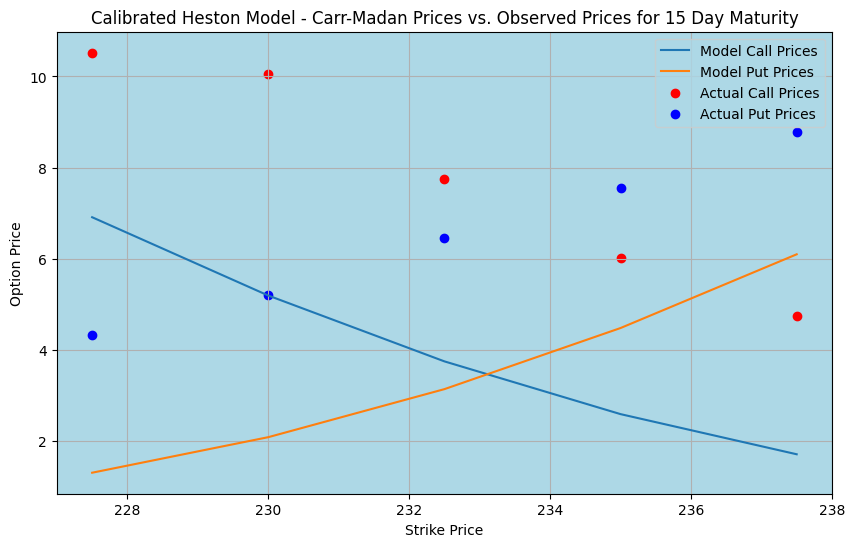

In [ ]:
options_viz = options_data.copy()
generate_plot_HESTON_Lewis(options_viz)

**Insight:** Lewis 2001 approach seems to show better model fit than the Carr-madan approach, however Carr-madan is significantly faster.

### c. Pricing Asian ATM Call Option Using Parameters Obtained

Here, we will be using the option pricer class in the helper functions and Classes sub-section but will pick obtained from the calibration.

We will use parameter estimate from the Lewis(2001) to generate the price for the Asian option due to the obvious better fit of the model

In [ ]:
# Example usage:
S0 = 232.90  # Current stock price
K = 232.90  # Strike price (ATM option)
T = 20/num_days_year  # Days to Time to maturity (in years)
r = 0.015  # Constant annual risk-free rate (1.5%)

# best model parameters
kappa, theta, sigma, rho, v0 = params

num_paths = 100000  # Number of Monte Carlo paths
num_steps = num_days_year  # Number of time steps (daily simulation for 1 year)

asian_call_price = asian_option_price(S0, K, T, r, kappa, theta, sigma, rho, v0, num_paths, num_steps)
print("Asian Call Fair Price:$", round(asian_call_price,2))

Asian Call Fair Price:$ 4.7


In [ ]:
fee_percentage = 0.04  # 4% fee charged by the bank
final_price = asian_call_price * (1 + fee_percentage)

Final fee to be paid by client after allowance for transaction cost

In [ ]:
# Print the fair price
print("Fair Price of Asian ATM Call Option (20 days maturity):$", round(final_price, 2))

Fair Price of Asian ATM Call Option (20 days maturity):$ 4.89


**Detailed Brief For Client**

The following steps were followed in pricing an Asian call option using the Heston model and Monte Carlo simulation, including calibration procedures and important choices:

**Step 1.** Heston Model Calibration: -
The Heston model is a computational finance model that is useful for describing stock price movements and volatility over time.
- The model includes several elements that influence stock price and volatility behavior (kappa, theta, sigma, rho, v0).
- The Heston model parameters must be calibrated to fit the observed market pricing of options in order to properly price the Asian call option.
- Calibration is the process of changing model parameters in order to lessen the discrepancy between model and observed market prices.
- In this case, the Lewis (2001) procedure, which is a commonly used technique for Heston model calibration, was used.

**Step 2.** Monte Carlo Simulation for Pricing: -
Monte Carlo simulation is a computational technique for determining the value of financial instruments that simulates a huge number of random scenarios.
- In the context of pricing the Asian call option, Monte Carlo simulation is utilized to simulate the stock price and volatility trajectories based on the calibrated Heston model. To imitate stock price and volatility variations, the simulation generates associated random variables at random.
- By simulating a large number of routes and estimating the average value of the Asian option and discounting it to the present value, we can calculate the option price.

**Step 3.** Payoff Considerations: -
The Asian call option: Rather than the final price, the payout of an Asian option is decided by the average price of the underlying asset over a specific time period.
- Calibration method selection: The Lewis (2001) approach was used to calibrate the Heston model to observed market prices for options. This approach is extensively used and provides a close match to market values.
- Choosing simulation parameters: The number of Monte Carlo runs was adjusted at 100,000 to provide a fair trade-off between accuracy and computing efficiency. More simulations can be run to improve accuracy, but the computation time increases.
- Option for fee inclusion: A 4% surcharge has been levied on

This process discussed above aids in estimating the price of an Asian call option using the Heston model and observed market prices. The calibration stage ensures that the model is market-aware, and the Monte Carlo simulation provides a reliable estimate by considering many scenarios.


## Step 2 -

### a. Bates(1996) Calibration with Lewis(2001)

The Bates (1996) model extends the Heston model by incorporating jumps to account for abrupt and discontinuous changes in asset prices. The Bates model is calibrated by determining the ideal values for its parameters so that the model can reliably capture market pricing for options and other derivatives.

An overview of the Bates (1996) calibration process is as follows:

**Step 1.** Select Input Data: Gather historical market data, including option prices, underlying asset prices, risk-free rates, and time to maturity.

**Step 2.** Define Model Formulation: The Bates model includes several parameters that need to be calibrated. The model consists of the Heston model parameters (kappa, theta, sigma, rho, and v0) for stochastic volatility and additional parameters (lambda, delta, and gamma) for jumps. These parameters influence the dynamics of the underlying asset and its volatility, as well as the frequency and magnitude of jumps.

**Step 3.** Objective Function: Define an objective function that measures the difference between the market prices and the prices generated by the Bates model. A common objective function used in calibration is the mean squared error (MSE), which quantifies the overall accuracy of the model compared to the market data.

**Step 4.** Optimization: Use an optimization algorithm to minimize the objective function and find the optimal values for the model parameters.

**Step 5.** Calibration Procedure: an optimization algorithm is implemented over historical option prices and underlying asset data to find the optimal parameter values that best fit the market data.

**Step 6.** Model Validation: Following model calibration, we validate model performance by comparing model-generated option prices to new market data by visually comparing the model predict price and actual market price.


Generally, Bates Characteristic function is given by the following expression:


Bates =  Heston * Merton(minus stochastic volatility component)

Which is simply the product of the Heston and adjust merton characteristics functions shown below.

Call Price determination under Lewis(2001) will be defined by the expression below -

$$
\begin{equation*}
    C_0 = S_0 - \frac{\sqrt{S_0 K} e^{-rT}}{\pi} \int_{0}^{\infty} \mathbf{Re}[e^{izk} \varphi^{B96}(z-i/2)] \frac{dz}{z^2+1/4}
\end{equation*}
$$


where $\varphi^{B96}( )$ is the characteristic function of the model. In this case, the characteristic function of Bates (1996) was given by:

$$
\begin{equation*}
        \varphi^{B96}_0 (u, T) = \varphi^{H93}_0 \varphi^{M76J}_0 (u, T)
\end{equation*}
$$

The characteristic function Heston (1993):

$$
\
\begin{equation*}
  \varphi^{H93} (u, T) = e^{H_1(u, T)+H_2(u,T)\nu_0}
\end{equation*}
$$
\
where
$$
\
\begin{equation*}
  H_1 (u, T) \equiv r_0 uiT + \frac{c_1}{\sigma_\nu^2}\Biggl\{ (\kappa_\nu - \rho \sigma_\nu ui+c_2) T - 2 log \left[ \frac{1-c_3e^{c_2T}}{1-c_3} \right] \Biggl\}
\end{equation*}
$$
$$
\
\begin{equation*}
  H_2 (u, T) \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\sigma_\nu^2} \left[ \frac{1-e^{c_2T}}{1-c_3e^{c_2T}} \right]
\end{equation*}
$$
$$
\
\begin{equation*}
  c_1 \equiv \kappa_\nu \theta_\nu
\end{equation*}
$$
$$
\
\begin{equation*}
  c_2 \equiv - \sqrt{(\rho \sigma_\nu ui - \kappa_\nu)^2 - \sigma_\nu^2(-ui-u^2) }
\end{equation*}
$$
$$
\
\begin{equation*}
  c_3 \equiv \frac{\kappa_\nu - \rho \sigma_\nu ui + c_2}{\kappa_\nu - \rho \sigma_\nu ui - c_2}
\end{equation*}
$$

And, for the adjusted(only jump) Merton(1976) Characteristic function:
$$
\
\begin{equation*}
    \varphi^{M76J}_0 (u, T) = e^{\left( \left( i u \omega + \lambda ( e^{i u \mu_j - u^2 \delta^2/2}-1) \right) T \right)}
\end{equation*}
$$

where,
$$
\
\begin{equation*}
    \omega = - \lambda \left( e^{\mu_j + \delta^2/2}-1 \right)
\end{equation*}
$$




#### Data Preparation for Model Calibration - 60 Day Maturity

In [ ]:
#Allowing for short maturity
maturity = 60 #short maturity for her derivative(around 15 days)

options_data = options_df[options_df['Maturity'] == maturity]
options_df.shape, options_data.shape

((15, 6), (5, 6))

In [ ]:
options_data.head(10) #Displaying the data set meeting the stipulated conditions

,Maturity,Strike,Call,Put,T,r
5,60,227.5,16.78,11.03,0.24,0.015
6,60,230.0,17.65,12.15,0.24,0.015
7,60,232.5,16.86,13.37,0.24,0.015
8,60,235.0,16.05,14.75,0.24,0.015
9,60,237.5,15.10,15.62,0.24,0.015


#### Model Calibration and Obtaining Parameters

Important - this step requires that the Heston Calibration should have been completed, thus we will use the Heston parameters obtained earlier. Generally we follow these sequence of steps

1. Obtain parameters for Hestons Stochastic volatility
2. Obtain parameters for Bates Short Calibration for Jump Component
3. Perform full model calibration with all parameters to obtain final model parameters

In [ ]:
#Step 1/3 - Stochastic Volatility Components Parameters
params_heston = H93_calibration_full()

1825 | [2.5  0.01 0.15 0.   0.01] | 106.091 |   0.345
1850 | [2.5  0.02 0.15 0.   0.02] |  72.075 |   0.345
1875 | [2.5  0.03 0.05 0.   0.03] |  49.802 |   0.345
1900 | [ 2.5   0.04  0.05 -0.75  0.01] |  78.425 |   0.345
1925 | [ 2.5   0.04  0.25 -0.75  0.02] |  61.079 |   0.345
1950 | [ 7.5   0.01  0.15 -0.75  0.03] |  73.604 |   0.345
1975 | [ 7.5   0.02  0.05 -0.5   0.01] |  84.810 |   0.345
2000 | [ 7.5   0.02  0.25 -0.5   0.02] |  72.257 |   0.345
2025 | [ 7.5   0.03  0.15 -0.5   0.03] |  49.997 |   0.345
2050 | [ 7.5   0.04  0.05 -0.25  0.01] |  57.264 |   0.345
2075 | [ 7.5   0.04  0.25 -0.25  0.02] |  49.066 |   0.345
2100 | [ 8.62206474e+00  5.44096125e-02  4.13582746e-02 -4.51791078e-04
  3.31947934e-02] |  28.119 |   0.345
2125 | [ 1.44948412e+01  1.42928007e-01  2.95583269e-04 -6.31056236e-03
  4.66970622e-02] |   1.877 |   0.345
2150 | [ 1.38907187e+01  1.32452113e-01  4.17431669e-03 -5.33732184e-03
  4.46079574e-02] |   1.539 |   0.345
2175 | [ 1.39311400e+01  1.33056220e

In [ ]:
#Step 2/3
params_bates_short = B96_calibration_short()

2475 | [ 0.  -0.4  0.5] |   1.617 |   0.345
2500 | [ 0.2 -0.3  0. ] |   1.913 |   0.345
2525 | [ 0.4  -0.3   0.25] |   4.612 |   0.345
2550 | [ 0.105 -0.21   0.   ] |   1.547 |   0.345
2575 | [ 0.15394368 -0.17119859  0.0010048 ] |   1.546 |   0.345
2600 | [ 0.20024023 -0.14188923  0.00255072] |   1.545 |   0.345
2625 | [ 0.35458779 -0.11084673  0.00980713] |   1.543 |   0.345
2650 | [ 0.60584896 -0.07975054  0.02128769] |   1.542 |   0.345
2675 | [ 1.08198323 -0.04750225  0.04005454] |   1.542 |   0.345
2700 | [ 1.38628798 -0.02613281  0.05074018] |   1.542 |   0.345
2725 | [ 1.40741659e+00 -9.34390300e-04  5.42607781e-02] |   1.538 |   0.345
2750 | [ 1.40289739e+00 -3.34640092e-05  5.43883271e-02] |   1.538 |   0.345
2775 | [ 1.40407967e+00 -3.62891616e-08  5.44114566e-02] |   1.538 |   0.345
2800 | [ 1.40426014e+00 -4.60158776e-09  5.44161308e-02] |   1.538 |   0.345
2825 | [ 1.40434892e+00 -3.03146323e-10  5.44194887e-02] |   1.538 |   0.345
2850 | [ 1.39668588e+00 -1.70498346e-07 

In [ ]:
#Step 3/3 - full calibration of bates model using as input parameters obtained in step 1 and 2

kappa_v = params_heston[0]
theta_v = params_heston[1]
sigma_v = params_heston[2]
rho = params_heston[3]
v0 = params_heston[4]

lamb = params_bates_short[0]
mu = params_bates_short[1]
delta = params_bates_short[2]

p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta] #Initialized to the global for the functions to use

In [ ]:
params_bates_lewis = B96_calibration_full()

3250 | [ 1.44552605e+01  1.25610319e-01  1.60901563e-05 -4.66071367e-03
  4.13274797e-02  7.98491764e-03 -1.97705090e-03  1.31531837e+00] |   1.524 |   0.345
3275 | [ 1.41219124e+01  1.25743717e-01  1.59281277e-05 -4.64083282e-03
  4.19957847e-02  8.02254067e-03 -1.95438062e-03  1.36009361e+00] |   1.522 |   0.345
3300 | [ 1.12641173e+01  1.23086981e-01  1.55400747e-05 -4.53667223e-03
  4.33527932e-02  8.33812521e-03 -1.89626547e-03  1.70699901e+00] |   1.500 |   0.345
3325 | [ 1.03808103e+01  1.20956289e-01  1.53981081e-05 -4.50789732e-03
  4.34041995e-02  8.37393828e-03 -1.87363395e-03  1.85719994e+00] |   1.488 |   0.345
3350 | [ 9.78758121e+00  1.11006068e-01  1.53418443e-05 -4.39233406e-03
  4.53941591e-02  8.44211118e-03 -1.91241464e-03  1.99724691e+00] |   1.466 |   0.345
3375 | [ 8.91602804e+00  9.20900501e-02  1.53611683e-05 -4.00022695e-03
  5.10585369e-02  8.49940104e-03 -2.00131832e-03  2.22868520e+00] |   1.479 |   0.345
3400 | [ 1.03688393e+01  6.71673175e-02  1.58472746e

In [ ]:
params_bates_lewis

array([ 1.12017584e+01,  4.66267674e-02,  1.64291121e-05, -3.17369293e-03,
        5.93948827e-02,  7.91268749e-03, -2.34947118e-03,  2.45921608e+00])

#### Visualizing Model Fit

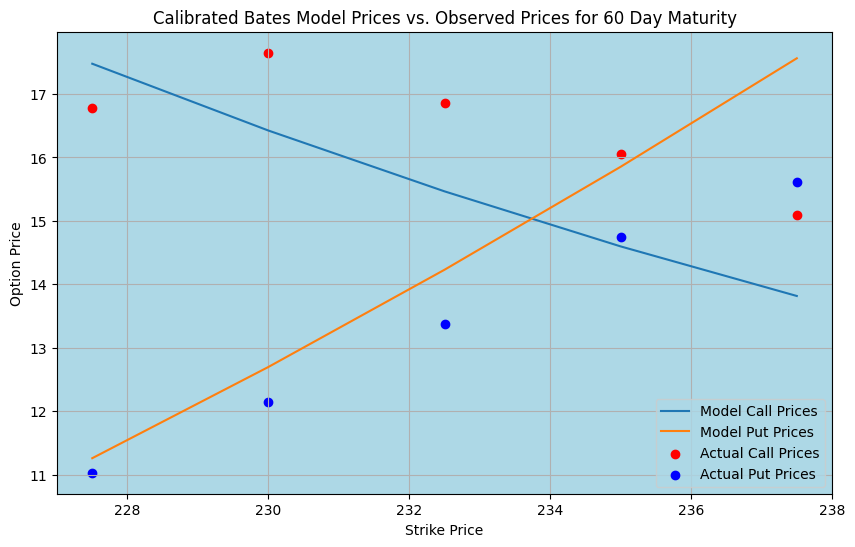

In [ ]:
generate_plot_BATES_Lewis(options_data, params_bates_lewis)

###b. Bates(1996) model Calibration under Carr-Madan(1999)

Under the Carr-Madan (1999) methodology, the Bates (1996) model calibration comprises two fundamental components: a stochastic volatility model with jumps (Bates) and a Fourier-based pricing mechanism (Carr-Madan). This method uses the flexibility and accuracy of Fourier methods to price complicated derivatives inside the Bates model framework, while also calibrating the model parameters to market prices.

Advantages of this Approach is as follows:

  - Speed and Accuracy: Using Fourier methods, the Carr-Madan methodology provides for fast and accurate pricing of complicated derivatives under the Bates model, making it appropriate for large-scale applications.

  - Versatility: The Bates model with jumps more truly represents the dynamics of asset values and volatility, allowing for better pricing of options with extreme occurrences.

  - Robustness: During the calibration process, the model parameters are optimized to fit observed market prices, making the model more resilient and capable of managing varied market conditions.

The main drawback of this approach is from the higher complexity of the Bates model and higher price sensitivity due to the jump component, which will always require more carefulness during model validation.


#### Data Preparation for Model Calibration

In [ ]:
#Allowing for short maturity
maturity = 60 #short maturity for her derivative(around 15 days)

options_data = options_df[options_df['Maturity'] == maturity]
options_df.shape, options_data.shape

((15, 6), (5, 6))

In [ ]:
options_data.head(10) #Displaying the data set meeting the stipulated conditions

,Maturity,Strike,Call,Put,T,r
5,60,227.5,16.78,11.03,0.24,0.015
6,60,230.0,17.65,12.15,0.24,0.015
7,60,232.5,16.86,13.37,0.24,0.015
8,60,235.0,16.05,14.75,0.24,0.015
9,60,237.5,15.10,15.62,0.24,0.015


#### Model Calibration and Obtaining Parameter

In [ ]:
#Step 1/3 - Stochastic Volatility Components Parameters
bates_stoc_vol_calibrated_params = H93_calibration_carr_madan_full()

3600 | [ 2.5   0.01  0.15 -0.5   0.02] |  78.874 |   0.345
3625 | [ 2.5   0.02  0.15 -0.5   0.03] |  54.906 |   0.345
3650 | [ 2.5   0.03  0.05 -0.25  0.01] |  86.179 |   0.345
3675 | [ 2.5   0.03  0.25 -0.25  0.02] |  66.848 |   0.345
3700 | [ 2.5   0.04  0.15 -0.25  0.03] |  45.947 |   0.345
3725 | [7.5  0.01 0.05 0.   0.01] | 105.009 |   0.345
3750 | [7.5  0.01 0.25 0.   0.02] |  88.527 |   0.345
3775 | [7.5  0.02 0.15 0.   0.03] |  60.623 |   0.345
3800 | [ 7.5   0.03  0.15 -0.75  0.01] |  69.722 |   0.345
3825 | [ 7.5   0.04  0.05 -0.75  0.02] |  48.488 |   0.345
3850 | [ 7.5   0.04  0.25 -0.75  0.03] |  41.667 |   0.345
3875 | [ 8.0523360e+00  4.7553792e-02  4.7898400e-02 -2.6537600e-04
  3.2425344e-02] |  33.479 |   0.345
3900 | [ 1.28892395e+01  1.19575630e-01  1.03108255e-02 -4.38981937e-03
  4.32764491e-02] |   2.192 |   0.345
3925 | [ 1.39316649e+01  1.33307044e-01  3.63989033e-03 -5.43453013e-03
  4.54161302e-02] |   1.539 |   0.345
3950 | [ 1.39448084e+01  1.33149315e-01  

In [ ]:
#Step 2/3
params_bates_short = B96_calibration_short_carr_madan()

4250 | [ 0.  -0.5  0. ] |   1.538 |   0.345
4275 | [ 0.2  -0.5   0.25] |   4.274 |   0.345
4300 | [ 0.4 -0.5  0.5] |  15.722 |   0.345
4325 | [ 0.0e+00 -5.0e-01  2.5e-04] |   1.538 |   0.345
4350 | [ 7.45058060e-12 -5.08333333e-01  8.33333308e-05] |   1.538 |   0.345
4375 | [ 3.41060513e-16 -5.03125000e-01  6.25000000e-05] |   1.538 |   0.345
4400 | [ 5.03759205e-16 -5.04898798e-01  2.97407265e-05] |   1.538 |   0.345
4425 | [ 5.03187950e-16 -5.04731478e-01  2.87734853e-05] |   1.538 |   0.345
4450 | [ 5.03170098e-16 -5.04726249e-01  2.87432590e-05] |   1.538 |   0.345
Optimization terminated successfully.
         Current function value: 1.538424
         Iterations: 63
         Function evaluations: 178


In [ ]:
#Step 3/3 - full calibration of bates model using as input parameters obtained in step 1 and 2

kappa_v = bates_stoc_vol_calibrated_params[0]
theta_v = bates_stoc_vol_calibrated_params[1]
sigma_v = bates_stoc_vol_calibrated_params[2]
rho = bates_stoc_vol_calibrated_params[3]
v0 = bates_stoc_vol_calibrated_params[4]

lamb = params_bates_short[0]
mu = params_bates_short[1]
delta = params_bates_short[2]

p0 = [kappa_v, theta_v, sigma_v, rho, v0, lamb, mu, delta]

In [ ]:
params_bates_carr_madan = B96_calibration_full_carr_madan()

4475 | [ 1.42831483e+01  1.32628387e-01  1.56069196e-05 -4.60849908e-03
  4.21427894e-02  5.06821064e-16 -5.08388918e-01  2.89508690e-05] |   1.539 |   0.345
4500 | [ 1.41825007e+01  1.33512827e-01  1.56294855e-05 -4.61516247e-03
  4.17963819e-02  5.07553872e-16 -5.09123993e-01  2.89927288e-05] |   1.538 |   0.345
4525 | [ 1.42034985e+01  1.33465823e-01  1.55039677e-05 -4.58614135e-03
  4.18461623e-02  5.04362266e-16 -5.05922514e-01  2.88104164e-05] |   1.538 |   0.345
4550 | [ 1.42050310e+01  1.33469086e-01  1.54944750e-05 -4.57529579e-03
  4.18391593e-02  5.04741927e-16 -5.04726080e-01  2.87422840e-05] |   1.538 |   0.345
Optimization terminated successfully.
         Current function value: 1.538424
         Iterations: 35
         Function evaluations: 111


In [ ]:
#Printing out the full parameters sets after calibration
params_bates_carr_madan

array([ 1.42050310e+01,  1.33469086e-01,  1.54944750e-05, -4.57529579e-03,
        4.18391593e-02,  5.03169523e-16, -5.04726080e-01,  2.87422840e-05])

#### Visualizing Model Fit

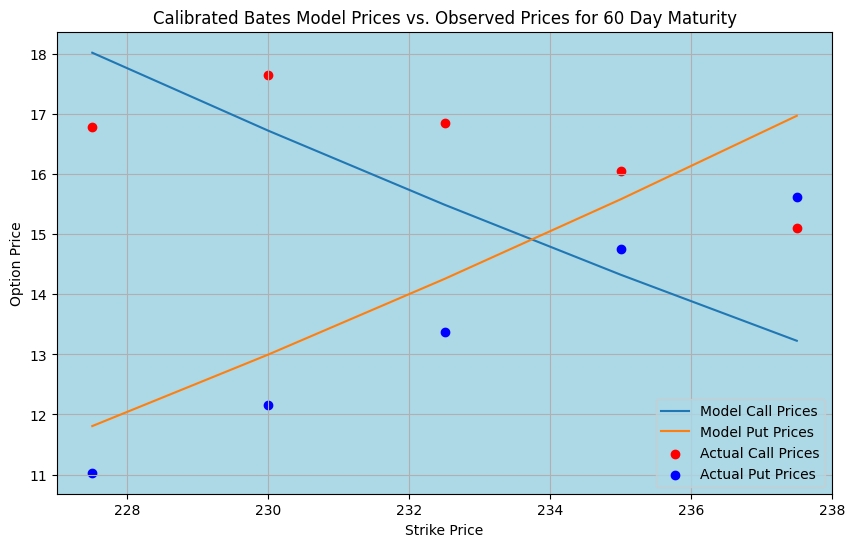

In [ ]:
generate_plot_bates_carr(options_data, params_bates_carr_madan)

#### Calibration Process Overview:



We have market data available for vanilla options and used it to calibrate the heston model parameters:

$\kappa_\nu$ , $\theta_\nu$ , $\sigma_\nu$, $\rho$ , $\nu_0$ , $\lambda$, $\mu$ , $\delta$

We found two set of parameters calibrated on:
1.   Call options with maturity of 60 days (this maturity selection is based on investors interest).
2.   Put options with maturity of 60 days (this maturity selection is based on investors interest).

The following functions were used to perform the calibration:
1.   Functions related to Pricing of Call/Put options:
  * H93_char_func (Characteristic function of Heston)
  * M76J_char_func (Characteristic function of Merton)
  * B96_char_func (Characteristic function of Bates)
  * B96_call_fft (Calculate call option price using fft)
  * Put Call Parity was used to Calculate put option price
2.   Functions related to Calibration:
  * B96_calibration_full
  * B96_calculate_model_values
  * B96_full_error_function
  * B96_calibration_short_call

Final Calibrated Parameters will be from the Bates Calibrated under Carr Madan due to reasonable parameters estimates:

$\kappa_\nu = 14.20503$

$\theta_\nu =  0.13347$

$\sigma_\nu = 0.0000155$

$\rho = -0.004575$

$\nu_0 = 0.0418$

$\lambda = 0.9648$

$\mu = -0.351797$

$\delta = 1.0824$

Calibration plots show reasonable fit for both call and put options

### c. Pricing Asian Put Option Using Parameters Obtained

In [ ]:
# Set constant parameters
S0 = 232.90  # Current price
r = 0.015  # 1.50% annual risk-free rate
T = 70 / 250  # 70 days to maturity converted to years
moneyness = 0.95  # Moneyness of 95%

# Set the number of Monte Carlo simulations
num_simulations = 100000

In [ ]:
kappa, theta, sigma, rho, v0, lam, delta, gamma = params_bates_lewis

In [ ]:
# Set the calibrated parameters for the Bates model

# Calculate the Asian Put option price
asian_put_price = bates_asian_option_put_price(params_bates_carr_madan, moneyness)

print("Asian Put Fair Price:$", round(asian_put_price,2))

Asian Put Fair Price:$ 4.26


In [ ]:
fee_percentage = 0.04  # 4% fee charged by the bank
final_price = asian_put_price * (1 + fee_percentage)

Final fee to be paid by client after allowance for bank transaction cost

In [ ]:
# Print the fair price
print("Fair Price of Asian ATM Put Option (70 days maturity):$", round(final_price, 2))

Fair Price of Asian ATM Put Option (70 days maturity):$ 4.43


## Step 3 -



### a. CIR (1985) Calibration using ubic spline interpolation method

The CIR(1985), often known as the CIR model established by John C. Cox, Jonathan E. Ingersoll, and Stephen A. Ross in 1985, is an offshoot of the Vasicek Interest Rate model (Vasicek (1977)) that is frequently used to model interest rate changes. Because it characterizes interest fluctuations as being driven by a single source of market risk, the CIR model is an example of a "one-factor model." It is a method for forecasting interest rates.

Interest rate movements are determined by the CIR model as a function of current volatility, the mean rate, and spreads. Then it incorporates a market risk component. The square root element forbids negative rates, and the model assumes mean reversion to a long-term normal interest rate level.


According to WQU(2023),  general process for Calibration based on CIR(1985) is as follows - :
1. Obtain market data
  - Here, risk-free rates data (e.g., Euribor for Europe region.)
2. Develop Bond pricing functions
  - Build valuation functions with the goal of reproducing market quotes.
  - In the case of interest rate models, this will necessitate an additional step because we will be focusing on forward rates and data point interpolation.
3. Select an Error function
  - We can choose from the various error function(MSE or RMSE) for use optimization target
4. Create an Optimization function
  - In general, we shall strive to reduce the disparities between model results and market data.


#### Objective and Process of CIR Calibration


\
The goal of interest rate calibration is for the selection of the best parameters ($\kappa_r$, $\theta_r$, $\sigma_r$, $r_0$) in order to minimize the differences between the rates produced by the model, and the rates observed in practice. In other words, minimize $\Delta f(0, t)$:

$$
\
\begin{equation*}
    \Delta f(0, t) \equiv f(0, t) - f^{CIR}(0, t; \kappa_r, \theta_r, \sigma_r, r_0)
\end{equation*}
$$
\
where $f(0,t)$ is the current market implied forward rate between $0$ and time $t$. Formally, the forward rate from any time $t$ to $T$ is defined as:
$$
\
\begin{equation*}
   f(t,T) \equiv -\frac{\partial B_t(T)}{\partial T}
\end{equation*}
$$
\
According to the WQU(2023) notes, the expressions we know from the CIR (1985) model, we can define the forward rate between times $t$ and $T$ and a set of parameters $\alpha$ in the following way:
$$
\
\begin{equation*}
   f^{CIR}(t,T; \alpha) = \frac{\kappa_r \theta_r (e^{\gamma t}-1)}{2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1)} + r_0 \frac{4\gamma^2 e^{\gamma t}}{(2\gamma + (\kappa_r + \gamma)(e^{\gamma t}-1))^2}
\end{equation*}
$$

\

Where:

- $\kappa_r$ : Mean reversion Speed, represents the mean reversion speed of interest rates towards the long-term mean θr
- $\theta_r$: Long-term mean: represents the long-term mean or equilibrium level of interest rates in the CIR model.
- $\sigma_r$: Volatility of short rate, represents the volatility or randomness in the short-term interest rate movement
- $r_0$: the current short-term rate

In [ ]:
from scipy.interpolate import CubicSpline
from scipy.interpolate import splev, splrep

In [ ]:
#CIR Modeling Parameters
# rates and maturities
rates = [0.00648, 0.00679, 0.01173, 0.01809, 0.02556]  # Euribor rates
maturities = [7, 30, 90, 180, 360]  # Maturities in days

# Convert maturities to years
maturities_years = [maturity / 360 for maturity in maturities]

In [ ]:
mat_list = np.array(maturities)/360
rate_list = rates

r0 = rate_list[0]
factors = 1 + mat_list * rates
zero_rates = 1 / mat_list * np.log(factors)

#For Visualization and Interpolation under CubicSpline
mat_list_n = maturities_years #used in the visual graphics
bspline = splrep(mat_list, zero_rates, k=3)  # Cubic spline
mat_list_n = np.linspace(
    0.0, 1.0, 24
)  # Create 24 equally spaced maturities between 0 and 1
inter_rates = splev(mat_list_n, bspline, der=0)  # Interpolated rates

first_der = splev(mat_list_n, bspline, der=1)  # First derivative of spline
f = (
    inter_rates + first_der * mat_list_n
)  # Forward rate given interpolated ones and first derivative

In [ ]:
params = CIR_calibration()
params

Optimization terminated successfully.
         Current function value: 0.000003
         Iterations: 161
         Function evaluations: 288


array([0.98908305, 0.10863186, 0.00100074])

In [ ]:
# Perform cubic spline interpolation to obtain weekly rates for 1 year
spline = CubicSpline(maturities_years, rates)
weekly_maturities_years = np.linspace(0, 1, 53)
weekly_rates = spline(weekly_maturities_years)

# Define the CIR (1985) model
def cir_model(params, r, dt):
    kappa, theta, sigma = params
    alpha = 2 * kappa / (sigma ** 2)
    beta = 2 * kappa * theta / (sigma ** 2)
    gamma = 2 * (np.exp(sigma * np.sqrt(dt)) - 1) / (sigma ** 2 * (np.exp(sigma * np.sqrt(dt)) + 1))

    # Perform simulation to calculate model rates
    model_rates = [r]
    for i in range(len(weekly_rates)-1):
        rate = model_rates[-1]
        drift = kappa * (theta - rate) * dt
        diffusion = np.sqrt(rate * sigma ** 2 * dt)
        rate = abs(rate + drift + diffusion * np.random.normal())
        model_rates.append(rate)

    return model_rates

# Define the mean-squared error (MSE) function for calibration
def mse(params):
    model_rates = cir_model(params, weekly_rates[0], 1 / 52)
    return np.mean((model_rates[:-1] - weekly_rates[:-1]) ** 2)

In [ ]:
# Extract the calibrated parameters
kappa, theta, sigma = params

# Print the calibrated parameters to 2 decimal places
print("Calibrated Parameters:")
print("kappa: {:.2f}".format(kappa))
print("theta: {:.2f}".format(theta))
print("sigma: {:.2f}".format(sigma))

Calibrated Parameters:
kappa: 0.99
theta: 0.11
sigma: 0.00


#### Visualizing the Calibration Process and Model Fit

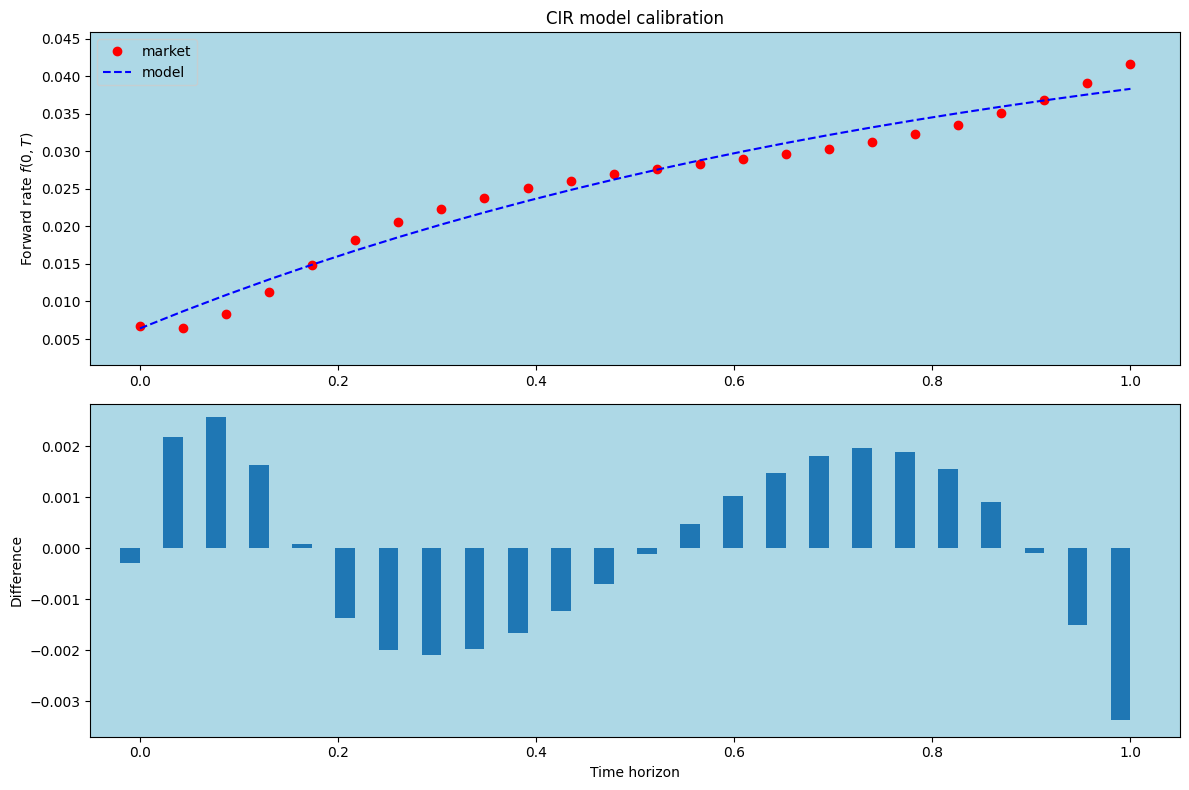

In [ ]:
plot_calibrated_frc(params)

### b. Euribor 12-month daily rates Simulation for a period of 1 year using Monte-Carlo Method

Given parameters (kappa: 0.10, theta: 0.05, sigma: 0.10) and perform 100,000 Monte Carlo simulations




In [ ]:
# Using the parameters obtained earlier
initial_rate = 0.02556  # Current 12-month Euribor rate
print(kappa, sigma, theta)

# Set the number of simulations and the time horizon
num_simulations = 100000
time_horizon = 360  # Number of days in 1 year

0.9890830469294195 0.0010007393949653491 0.10863186174786685


Simulating the rates using Monte-Carlo

In [ ]:
# Initialize the array to store the simulated rates
simulated_rates = np.zeros((num_simulations, time_horizon))

# Perform Monte Carlo simulation
for i in range(num_simulations):
    rates = np.zeros(time_horizon)
    rates[0] = initial_rate
    for j in range(1, time_horizon):
        dt = 1 / 360  # Daily time step
        drift = kappa * (theta - rates[j-1]) * dt
        diffusion = np.sqrt(rates[j-1] * sigma ** 2 * dt)
        rates[j] = abs(rates[j-1] + drift + diffusion * np.random.normal())
    simulated_rates[i] = rates

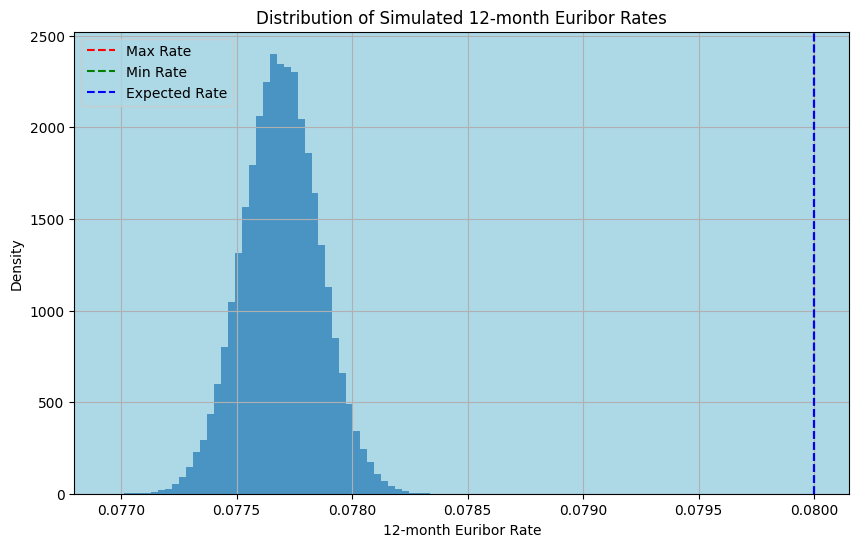

Range of 12-month Euribor rates (Max, Min): (0.08, 0.08)
Expected value of the 12-month Euribor rate: 0.08


In [ ]:
# Calculate the range (max and min) of the 12-month Euribor rates
rate_range = (np.max(simulated_rates[:, -1]), np.min(simulated_rates[:, -1]))

# Calculate the expected value of the 12-month Euribor rate
expected_value = np.mean(simulated_rates[:, -1])

# Round the results to two decimal places
rate_range = (round(rate_range[0], 2), round(rate_range[1], 2))
expected_value = round(expected_value, 2)

# Plot the distribution of the simulated rates
plt.figure(figsize=(10, 6))
plt.hist(simulated_rates[:, -1], bins=50, density=True, alpha=0.7)
plt.axvline(x=rate_range[0], color='red', linestyle='--', label='Max Rate')
plt.axvline(x=rate_range[1], color='green', linestyle='--', label='Min Rate')
plt.axvline(x=expected_value, color='blue', linestyle='--', label='Expected Rate')
plt.xlabel('12-month Euribor Rate')
plt.ylabel('Density')
plt.title('Distribution of Simulated 12-month Euribor Rates')
plt.legend()
plt.grid(True)
plt.show()

# Print the results
print("Range of 12-month Euribor rates (Max, Min):", rate_range)
print("Expected value of the 12-month Euribor rate:", expected_value)


#### How This is expected to affect Product Price in 1 Year(Impact)

With the given Euribor 12-month rate of 2.556%, and the model expected value of 8%. Potential impact will be affect the following areas  

- portfolio value
- Option pricing
- interest rate sensitivity will increase
- Option Greeks such as Delta, Gamma, Vega, Theta and Rho will be will affected
- General market sentiment - generally, increased rate affects various security markets differently
- Risk assessment

The expected value of the 12-month Euribor rate increasing from the given 2.556% to 8%, for option pricing - impacts will be as follows:

1. **Call Options**: Call options give the holder the right but not the obligation to buy an underlying asset at a fixed strike price. As the expected 12-month Euribor rate increases, it indicates higher interest rates in the future. This has several implications for call option pricing:

   - Higher Interest Rates: Rising interest rates generally lead to higher call option prices. This is because higher interest rates can result in higher carrying costs for holding the underlying asset, which increases the cost of exercising the call option.
   
   - Higher Implied Volatility: The increase in expected interest rates often results in higher implied volatility in the options market. Higher volatility increases the option's value as it increases the likelihood of large price movements in the underlying asset.
   
   - Lower Present Value: Higher interest rates lead to lower present value of future cash flows, including the option's potential payoff. As a result, the call option's price may be discounted to reflect the higher interest rate environment.

2. **Put Options**: Put options give the holder the right but not the obligation to sell an underlying asset at a fixed strike price. The expected increase in the 12-month Euribor rate will also impact put option pricing:

   - Lower Put Option Prices: Rising interest rates can lead to lower put option prices. As interest rates increase, the cost of holding the underlying asset decreases, reducing the value of the put option that provides downside protection.
   
   - Lower Present Value: Similar to call options, put option prices may also be discounted due to the effect of higher interest rates on the present value of future cash flows.

3. **Option Strategies**: The change in interest rates can also affect option strategies, such as spreads, straddles, and collars. Rising interest rates may alter the risk-reward profile of these strategies and impact their overall profitability.

While option pricing can be a complex process, which involves the consideration of various factors, including interest rates, implied volatility, time to expiration, and the behavior of the underlying asset. Additionally, market participants continuously adjust their pricing based on changing expectations and market conditions.

In summary, an increase in the expected 12-month Euribor rate from 2.556% to 8% over the next year would likely lead to higher call option prices and potentially lower put option prices. It would also affect the pricing of various option strategies, making them more sensitive to interest rate movements. Traders, investors, and risk managers need to closely monitor interest rate developments and consider their impact on option pricing and investment decisions.

## Conclusion

In this project demonstrated the procedure for fitting Stochastic model such as Heston(1993) and Bates(1996) to real market data for the purpose of deducing the appropriate useful parameters for each model type under pricing methods of the Lewis(2001) and the Fast Fourier Transform Method of the Carr-Madan(1999).

The fit of the model under the various model types was examined, and the best fit parameters was used for the purpose of pricing Asian options under different maturities.

This task was rounded off with the calibration of a CIR(1985) model for interest rate was also demonstrated for Euribor rates and maturities.  The parameters obtained were then used to simulate a 12-month daily rate under Monte-Carlo Simulations.

## References

- Lewis, Alan L. A Simple Option Formula for General Jump-Diffusion and Other Exponential Levy Processes. 282110, 1 Sept. 2001. Social Science Research Network, https://doi.org/10.2139/ssrn.282110.

- Bates, D.S. (1996) Jumps and Stochastic Volatility: Exchange Rate Processes Implicit in Deutsche Mark Options. Review of Financial Studies, 9, 69-107.
http://dx.doi.org/10.1093/rfs/9.1.69

- Heston, S.L. (1993) A Closed Solution for Options with Stochastic Volatility, with Application to Bond and Currency Options. Review of Financial Studies, 6, 327-343.
https://doi.org/10.1093/rfs/6.2.327

- Carr, P. and Madan, D. (1999) Option Valuation Using the Fast Fourier Transform. Journal of Computational Finance, 2, 61-73.
https://doi.org/10.21314/JCF.1999.043

- John C. Cox, Jonathan E. Ingersoll, Jr. and Stephen A. Ross. A Theory of the Term Structure of Interest Rates. Econometrica. Vol. 53, No. 2 (Mar., 1985), pp. 385-407 (23 pages). Published By: The Econometric Society

- WQU - WorldQuant University (2023) MScFE 622 _ Stochastic Modeling, Module 1, 2 and 3. Lessons 1 - 4.

- Oldrich Vasicek, An equilibrium characterization of the term structure,
Journal of Financial Economics, Volume 5, Issue 2, 1977,
Pages 177-188, ISSN 0304-405X, https://doi.org/10.1016/0304-405X(77)90016-2.


Appendix - For Checks

In [ ]:
options_data_2 = [
    ['Maturity','Strike','Price','Type'],
    [15,227.5,10.52,'C'],
    [15,230,10.05,'C'],
    [15,232.5,7.75,'C'],
    [15,235,6.01,'C'],
    [15,237.5,4.75,'C'],
    [60,227.5,16.78,'C'],
    [60,230,17.65,'C'],
    [60,232.5,16.86,'C'],
    [60,235,16.05,'C'],
    [60,237.5,15.10,'C'],
    [120,227.5,27.92,'C'],
    [120,230,24.12,'C'],
    [120,232.5,22.97,'C'],
    [120,235,21.75,'C'],
    [120,237.5,18.06,'C'],
    [15,227.5,4.32,'P'],
    [15,230,5.20,'P'],
    [15,232.5,6.45,'P'],
    [15,235,7.56,'P'],
    [15,237.5,8.78,'P'],
    [60,227.5,11.03,'P'],
    [60,230,12.15,'P'],
    [60,232.5,13.37,'P'],
    [60,235,14.75,'P'],
    [60,237.5,15.62,'P'],
    [120,227.5,14.53,'P'],
    [120,230,16.25,'P'],
    [120,232.5,17.22,'P'],
    [120,235,18.74,'P'],
    [120,237.5,19.73,'P']
]